<a href="https://colab.research.google.com/github/maysahayu/Collab-Project/blob/main/scrap_prepro_fe_cluster_Webtoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests as req
from bs4 import BeautifulSoup as bs
import pandas as pd
import csv
import os
hades = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}

In [ ]:
# SCRAPING DATA

def scraping_springer():
    data_list = []
    base_url = "https://www.webtoons.com/id/"
    headers = {'User-Agent': 'Mozilla/5.0'}
    genres = ["drama", "fantasy", "romantic_fantasy", "comedy", "action", "slice_of_life", "romance", "thriller", "horror", "local"]

    for page in genres:
        url = f"https://www.webtoons.com/id/genres/{page}?sortOrder=READ_COUNT"

        try:
            halaman_utama = req.get(url, headers=headers).text
            soup = bs(halaman_utama, 'lxml')

            comics = soup.select('ul.card_lst a.card_item')

            if not comics:
                print(f"Tidak ada artikel ditemukan di halaman {page}.")
                continue

            for comic in comics:
                judul_element = comic.find('p', class_='subj')
                judul = judul_element.text.strip() if judul_element else 'Judul tidak ditemukan'

                author_element = comic.find('p', class_='author')
                author = author_element.text.strip() if author_element else 'Author tidak ditemukan'

                # URL halaman detail komik
                detail_url = comic['href']

                # Masuk ke halaman detail untuk mengambil ringkasan
                try:
                    detail_page = req.get(detail_url, headers=headers).text
                    detail_soup = bs(detail_page, 'lxml')

                    # Cari elemen ringkasan di halaman detail
                    desc_element = detail_soup.find('p', class_='summary')
                    desc = desc_element.text.strip() if desc_element else 'Ringkasan tidak ditemukan'

                except Exception as e:
                    print(f"Terjadi kesalahan saat mengakses {detail_url}: {e}")
                    desc = 'Ringkasan tidak ditemukan'  # Menangani jika halaman detail gagal diakses

                # Menambahkan data komik yang berhasil di-scrape
                data_list.append([judul, author, desc])

        except Exception as e:
            print(f"Terjadi kesalahan saat mengakses {url}: {e}")

    # Menampilkan hasil scraping dalam bentuk DataFrame
    df = pd.DataFrame(data_list, columns=['Judul Komik', 'Author', 'Ringkasan'])
    print(df)

    # Menyimpan DataFrame ke dalam file CSV
    df.to_csv('data_webtoon.csv', index=False, encoding='utf-8')

    print("Data berhasil disimpan")


In [ ]:
scraping_springer()

                     Judul Komik                     Author  \
0                        LOOKISM               Taejoon Park   
1                   Girl's World                    morangg   
2                The Real Lesson  CHAE YONGTAEK / HAN GARAM   
3     Undercover at Chaebol High                         AJ   
4               GOOD/BAD FORTUNE               Ariel Duyung   
...                          ...                        ...   
1499      SCRAMBLED: Journeylism                Lintankleen   
1500                Dracko Diary                   Indra AD   
1501                Perhaps Mine         Cikakey / Candrasa   
1502                 Summer Rain                  kiyoshin_   
1503                  Oh My Boy!                     Kanipa   

                                              Ringkasan  
0        Cowok ini punya 2 wujud! Pilih yang mana ya..?  
1      Jadi bebek di antara para angsa? We will surive!  
2     Setelah undang-undang larangan memukul para si...  
3     Lee D

In [ ]:
# PRE PROCESSING DATA

import pandas as pd
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

# File paths
file_path = "data_webtoon.csv"
output_path = "prepro_webtoon.csv"
kamus_alay = "colloquial-indonesian-lexicon.csv"

kolom_target = 'Ringkasan'  # Kolom target yang akan diproses

# Mendapatkan daftar stopwords
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk menghilangkan tanda baca
def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

# Fungsi untuk menghilangkan URL dari teks
def remove_url(text):
    if isinstance(text, str):
        url_pattern = r'http\S+|www\S+'
        return re.sub(url_pattern, '', text)
    return text

# Fungsi untuk menghilangkan HTML tags dari teks
def remove_html_tags(text):
    if isinstance(text, str):
        return re.sub(r'<.*?>', '', text)  # Menghapus semua yang ada di antara <>
    return text

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = re.findall(r'\b\w+\b', text)  # Mengambil kata-kata yang valid
        return ' '.join([word for word in words if word not in stop_words])
    return text

def remove_digits(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)  # Menghapus semua digit
    return text

# Fungsi untuk mengonversi emoji menjadi teks deskripsi sederhana
def convert_emoji_to_text(text):
    if isinstance(text, str):
        return emoji.demojize(text)  # Mengonversi emoji menjadi teks
    return text

# Fungsi untuk menghilangkan simbol yang tidak diinginkan
def remove_special_characters(text):
    if isinstance(text, str):
        return text.replace("ð", "").replace("â", "").replace("º", "").replace("ï", "")
    return text

# Membaca file Kamus Alay dan membuat dictionary alay -> formal
df_slang = pd.read_csv(kamus_alay)
alay_dict = dict(zip(df_slang['slang'], df_slang['formal']))

# Fungsi untuk mengganti kata alay dengan kata formal
def normalize_alay(text):
    if isinstance(text, str):
        return ' '.join([alay_dict.get(word, word) for word in text.split()])
    return text

# Membaca file CSV
data = pd.read_csv(file_path)

# Mengubah teks menjadi lowercase pada kolom target
data[kolom_target] = data[kolom_target].str.lower()

# Menghapus URL terlebih dahulu
data[kolom_target] = data[kolom_target].apply(remove_url)

# Menghapus HTML tags setelah URL dihilangkan
data[kolom_target] = data[kolom_target].apply(remove_html_tags)

# Menghapus tanda baca setelah URL dihilangkan
data[kolom_target] = data[kolom_target].apply(remove_punctuation)

# Mengonversi emoji menjadi deskripsi teks sederhana
data[kolom_target] = data[kolom_target].apply(convert_emoji_to_text)

# Menghilangkan simbol yang tidak diinginkan dari teks
data[kolom_target] = data[kolom_target].apply(remove_special_characters)

# Menghapus digit angka
data[kolom_target] = data[kolom_target].apply(remove_digits)

# Menghapus stopwords
data[kolom_target] = data[kolom_target].apply(remove_stopwords)

# Mengganti kata-kata alay dengan kata formal
data[kolom_target] = data[kolom_target].apply(normalize_alay)

# Menyimpan hasilnya kembali ke file CSV
data.to_csv(output_path, index=False)

print(f"Semua teks telah diubah ke huruf kecil, URL, tanda baca, emoji telah dikonversi, stopwords, dan kata alay pada kolom '{kolom_target}' telah dihapus/diganti, dan file disimpan sebagai '{output_path}'")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Semua teks telah diubah ke huruf kecil, URL, tanda baca, emoji telah dikonversi, stopwords, dan kata alay pada kolom 'Ringkasan' telah dihapus/diganti, dan file disimpan sebagai 'prepro_webtoon.csv'


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Judul Komik  1504 non-null   object
 1   Author       1502 non-null   object
 2   Ringkasan    1504 non-null   object
dtypes: object(3)
memory usage: 35.4+ KB


In [ ]:
data['Ringkasan'].value_counts()

,count
Ringkasan,
sama nana kesulitan berteman bertemu kawankawan barunya sekolah harihari nana sepi diisi kisah persahabatan manis rumit,4
kisah gadis desa bernama sarmi rahayu ning tyas hayu antusias mengubah hidupnya gitugitu nekat kota kuliah berharap membesarkan usaha ibunya pembuat jamu tradisional disangka bertemu rendaru ganendra ndaru teman kecilnya bertahuntahun bertemu parasnya berubah putih bersih pokoknya tipe hayu banget sayang dikelilingi orangorang mengerikan rumor miring tentangnya hayu dengannya mengemban tudingan mirinya tersemat,4
aru bersuara insiden bantuan teman kecilnya kiran temanteman aru berusaha menjalani kehidupan sekolah berkomunikasi berbeda,4
rion berpikir hidupnya kedatangan siswi bell menghancurkan tatapan mata bell mengendalikan bunuh bertekad membalaskan dendamnya rion,4
frana sih cewek tomboy memutuskan merubah cewek feminin disaat berubah orangorang menerima perubahannya frana memutuskan merantau pulau berharap menjalani hidup indah kehidupan frana sesuai ekspektasinya,4
...,...
yoon garam pembelot korea utara tumbuh psikopat eksperimen dihadapinya dikirim membalaskan dendam lee hyena ayah hyena lee myungjoon terima anaknya tewas mengenaskan pembullyan parah sekolah terlambat balas dendam rencana penuh permainan pembalasan dendam berjalan sesuai rencana content warning memicu trauma kekerasan,1
ya leejin satusatunya orang hidup kecelakaan pesawat terbang tentara bayaran asalnya kehidupan sabagai anak sama bersekolah normal,1
killer legendaris bernama peter tua sakitsakitan diincar matimatian tertangkap salah kelompok mengincarnya menghilang terluka parah peter wujudnya remaja kuat raga muda sehat rencana peter perubahan hidupnya masuk akal,1


In [ ]:
count_wd = []
for word in data['Ringkasan']:
    count = len(word.split())
    count_wd.append(count)
data['count_words'] = count_wd
data

,Judul Komik,Author,Ringkasan,count_words
0,LOOKISM,Taejoon Park,cowok wujud pilih ya,4
1,Girl's World,morangg,bebek angsa we will surive,5
2,The Real Lesson,CHAE YONGTAEK / HAN GARAM,undangundang larangan memukul siswa disahkan s...,14
3,Undercover at Chaebol High,AJ,lee dakyung anggota sebuh organisasi gelap ter...,43
4,GOOD/BAD FORTUNE,Ariel Duyung,hatihati bertemu nasib berubah,4
...,...,...,...,...
1499,SCRAMBLED: Journeylism,Lintankleen,visi siswi sama pemalu memutuskan mengikuti ek...,21
1500,Dracko Diary,Indra AD,dracko pergi merantau mengejar citacitanya ani...,6
1501,Perhaps Mine,Cikakey / Candrasa,mine dipecat insiden mendadak gaji pengurus ba...,11
1502,Summer Rain,kiyoshin_,aneh hujan panas salah satunya dialami kay gad...,16


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

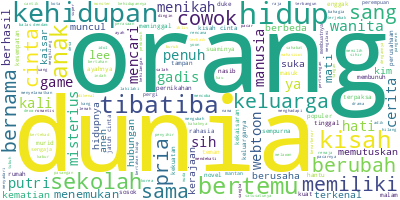

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(data['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = data['Ringkasan'].to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
data_FE = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
data_FE

,aaron,abad,abadi,abang,abi,absurd,acara,acaraacara,achelans,adakah,...,yusin,zahra,zaman,zan,zara,zener,zenus,zeron,zion,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Columns: 6284 entries, aaron to zombie
dtypes: float64(6284)
memory usage: 72.1 MB


In [ ]:
# FEATURE ENGINEERING (BOW)

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cleaned_file_path = "prepro_webtoon.csv"
output_bow_path = "fe_webtoon.csv"

df_cleaned = pd.read_csv(cleaned_file_path)

df_cleaned['Ringkasan'] = df_cleaned['Ringkasan'].fillna('')

df_cleaned['Ringkasan'] = df_cleaned['Ringkasan'].astype(str)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_cleaned['Ringkasan'])

bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


bow_df.to_csv(output_bow_path, index=False)

print(f"Hasil Bag of Words telah disimpan ke dalam file '{output_bow_path}'")

print(bow_df.head())

Hasil Bag of Words telah disimpan ke dalam file 'fe_webtoon.csv'
   aaron  abad  abadi  abang  abi  absurd  acara  acaraacara  achelans  \
0      0     0      0      0    0       0      0           0         0   
1      0     0      0      0    0       0      0           0         0   
2      0     0      0      0    0       0      0           0         0   
3      0     0      0      0    0       0      0           0         0   
4      0     0      0      0    0       0      0           0         0   

   adakah  ...  yusin  zahra  zaman  zan  zara  zener  zenus  zeron  zion  \
0       0  ...      0      0      0    0     0      0      0      0     0   
1       0  ...      0      0      0    0     0      0      0      0     0   
2       0  ...      0      0      0    0     0      0      0      0     0   
3       0  ...      0      0      0    0     0      0      0      0     0   
4       0  ...      0      0      0    0     0      0      0      0     0   

   zombie  
0       0  
1  

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k = range(1,10)
inertia = []

for i in k:
    km_model = KMeans(n_clusters=i) # jumlah cluster akan di looping
    km_model.fit(data_FE)
    inertia.append(km_model.inertia_)

print(list(k))
print(inertia)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1491.183723199567, 1487.885585414346, 1484.5044226482266, 1480.0885616506569, 1476.4318749781592, 1473.6061374250937, 1469.7700869160035, 1467.6562921904963, 1464.857848680595]


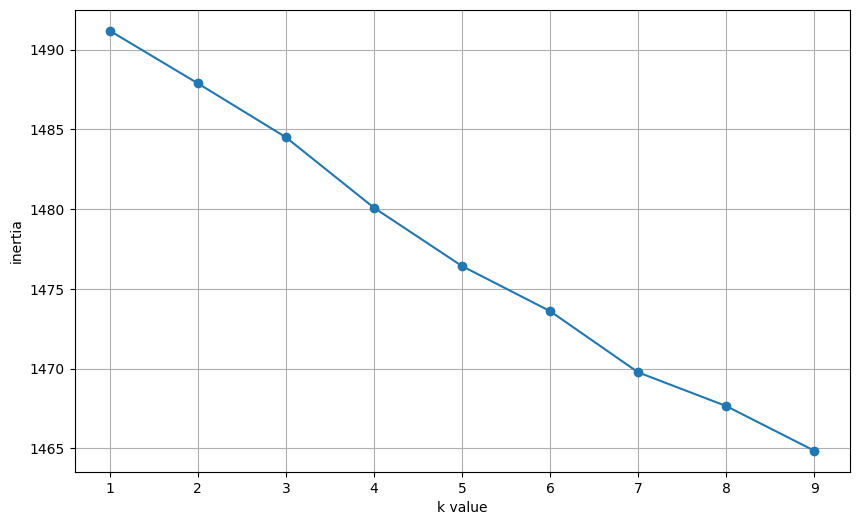

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(k, inertia, marker='o')
plt.xlabel('k value')
plt.ylabel('inertia')
plt.grid()
plt.show()

In [ ]:
kn5 = KMeans(n_clusters=5, random_state=1).fit(data_FE)
kn5

KMeans(n_clusters=5, random_state=1)

In [ ]:
kn5.labels_

array([3, 3, 3, ..., 1, 0, 1], dtype=int32)

## Hierarchical

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

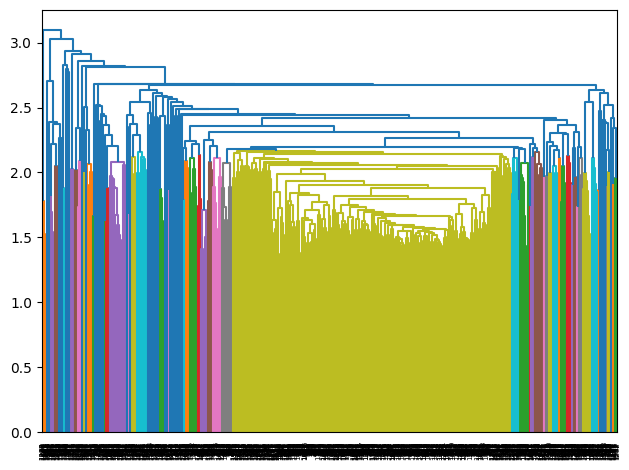

In [ ]:
linkage_data = linkage(data_FE, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
labels = hierarchical_cluster.fit(data_FE)

pred_agc = pd.Series(hierarchical_cluster.labels_)

# Silhouette Score

In [ ]:
from sklearn import metrics
labels = kn5.labels_
metrics.silhouette_score(data_FE, labels, metric='euclidean')

0.0034028528611340374

In [ ]:
from sklearn import metrics
labels = pred_agc
metrics.silhouette_score(data_FE, labels, metric='euclidean')

0.0031412813449601218

# Word Cloud Hasil Setiap Cluster

# Kmeans

In [ ]:
data_Kmeans = data.copy(deep=True)
data_Kmeans['cluster'] = kn5.labels_
data_Kmeans

,Judul Komik,Author,Ringkasan,count_words,cluster
0,LOOKISM,Taejoon Park,cowok wujud pilih ya,4,3
1,Girl's World,morangg,bebek angsa we will surive,5,3
2,The Real Lesson,CHAE YONGTAEK / HAN GARAM,undangundang larangan memukul siswa disahkan s...,14,3
3,Undercover at Chaebol High,AJ,lee dakyung anggota sebuh organisasi gelap ter...,43,2
4,GOOD/BAD FORTUNE,Ariel Duyung,hatihati bertemu nasib berubah,4,2
...,...,...,...,...,...
1499,SCRAMBLED: Journeylism,Lintankleen,visi siswi sama pemalu memutuskan mengikuti ek...,21,2
1500,Dracko Diary,Indra AD,dracko pergi merantau mengejar citacitanya ani...,6,3
1501,Perhaps Mine,Cikakey / Candrasa,mine dipecat insiden mendadak gaji pengurus ba...,11,1
1502,Summer Rain,kiyoshin_,aneh hujan panas salah satunya dialami kay gad...,16,0


Kmeans for cluster 0


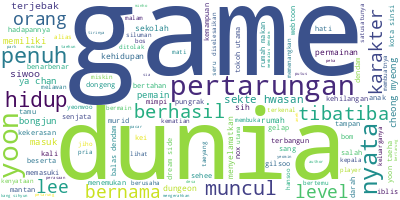

In [ ]:
c=0

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 1


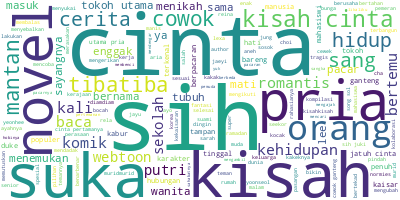

In [ ]:
c=1

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 2


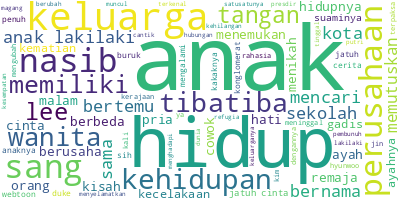

In [ ]:
c=2

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 3


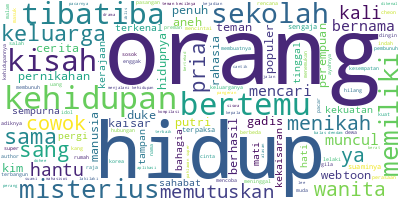

In [ ]:
c=3

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Kmeans for cluster 4


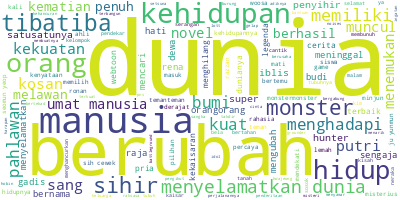

In [ ]:
c=4

print('Kmeans for cluster '+str(c))
data_c = data_Kmeans[data_Kmeans['cluster'] == c]
# Join the different processed titles together.
long_string = ','.join(list(data_c['Ringkasan'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
data_agg = data.copy(deep=True)
data_agg['cluster'] = kn5.labels_
data_agg

,Judul Komik,Author,Ringkasan,count_words,cluster
0,LOOKISM,Taejoon Park,cowok wujud pilih ya,4,3
1,Girl's World,morangg,bebek angsa we will surive,5,3
2,The Real Lesson,CHAE YONGTAEK / HAN GARAM,undangundang larangan memukul siswa disahkan s...,14,3
3,Undercover at Chaebol High,AJ,lee dakyung anggota sebuh organisasi gelap ter...,43,2
4,GOOD/BAD FORTUNE,Ariel Duyung,hatihati bertemu nasib berubah,4,2
...,...,...,...,...,...
1499,SCRAMBLED: Journeylism,Lintankleen,visi siswi sama pemalu memutuskan mengikuti ek...,21,2
1500,Dracko Diary,Indra AD,dracko pergi merantau mengejar citacitanya ani...,6,3
1501,Perhaps Mine,Cikakey / Candrasa,mine dipecat insiden mendadak gaji pengurus ba...,11,1
1502,Summer Rain,kiyoshin_,aneh hujan panas salah satunya dialami kay gad...,16,0
